In [4]:
import requests
import pandas as pd
import re

BASE = "https://api.openf1.org/v1"

def get_json(endpoint: str, params: dict) -> list:
    r = requests.get(f"{BASE}/{endpoint}", params=params, timeout=30)
    r.raise_for_status()
    return r.json()

# ---------- 1) Meeting (Singapour 2025)
meetings = get_json("meetings", {"country_name": "Singapore", "year": 2025})
if not meetings:
    raise RuntimeError("Aucun meeting trouvé pour Singapore 2025.")
meetings_df = pd.DataFrame(meetings).sort_values("date_start")
meeting_key = int(meetings_df.iloc[-1]["meeting_key"])

# ---------- 2) Trouver les sessions FP1/FP2/FP3 de manière robuste
def find_one_session(meeting_key: int, target_code: str, target_name: str):
    # Essai 1 : par code (ex: FP1)
    s = get_json("sessions", {"meeting_key": meeting_key, "session_code": target_code})
    if s:
        d = s[0]
        return int(d["session_key"]), d.get("session_code", target_code), d.get("session_name", target_name)

    # Essai 2 : par nom exact (ex: "Practice 1")
    s = get_json("sessions", {"meeting_key": meeting_key, "session_name": target_name})
    if s:
        d = s[0]
        # fallback si session_code absent
        return int(d["session_key"]), d.get("session_code", target_code), d.get("session_name", target_name)

    # Essai 3 : rechercher dans toutes les sessions, pattern sur le nom
    sessions_all = get_json("sessions", {"meeting_key": meeting_key})
    if sessions_all:
        sdf = pd.DataFrame(sessions_all)
        # Normalise
        name_col = "session_name" if "session_name" in sdf.columns else None
        code_col = "session_code" if "session_code" in sdf.columns else None

        # Cherche d'abord par code si dispo
        if code_col and sdf[code_col].notna().any():
            hit = sdf.loc[sdf[code_col].astype(str).str.upper() == target_code]
            if not hit.empty:
                d = hit.iloc[0].to_dict()
                return int(d["session_key"]), d.get("session_code", target_code), d.get("session_name", target_name)

        # Puis par nom si dispo
        if name_col and sdf[name_col].notna().any():
            # match "Practice X" ou "Free Practice X" insensible à la casse
            pattern = re.compile(rf"(practice|free\s*practice)\s*{target_code[-1]}", re.IGNORECASE)
            mask = sdf[name_col].astype(str).str.contains(pattern)
            hit = sdf.loc[mask]
            if not hit.empty:
                d = hit.iloc[0].to_dict()
                return int(d["session_key"]), d.get("session_code", target_code), d.get("session_name", target_name)

    # Échec → None
    return None

targets = [("FP1", "Practice 1"), ("FP2", "Practice 2"), ("FP3", "Practice 3")]
found = []
for code, name in targets:
    sess = find_one_session(meeting_key, code, name)
    if sess:
        found.append(sess)

if not found:
    raise RuntimeError("Aucune des sessions FP1/FP2/FP3 n'a été trouvée pour ce meeting.")

# Affiche ce qui a été trouvé
print("Sessions retenues :")
for (sk, sc, sn) in found:
    print(f"- {sc} | {sn} | session_key={sk}")

def build_session_laps_with_tyres(session_key: int, session_code: str, session_name: str) -> pd.DataFrame:
    # 3) Laps
    laps = get_json("laps", {"session_key": session_key})
    laps_df = pd.DataFrame(laps)
    if laps_df.empty:
        return pd.DataFrame(columns=[
            "session_code", "session_name",
            "driver_number", "lap_number", "lap_duration", "is_pit_out_lap",
            "stint_number", "compound", "tyre_age_at_start",
            "tyre_lap_start", "tyre_lap_end", "laps_on_tyre", "laps_on_this_tyre",
            "is_first_lap_on_tyre", "is_last_lap_on_tyre",
            "full_name", "name_acronym", "team_name", "team_colour"
        ])

    laps_df["driver_number"] = laps_df["driver_number"].astype(int)
    laps_df["lap_number"] = laps_df["lap_number"].astype(int)

    # 4) Stints
    stints = get_json("stints", {"session_key": session_key})
    stints_df = pd.DataFrame(stints)
    if stints_df.empty:
        return pd.DataFrame(columns=[
            "session_code", "session_name",
            "driver_number", "lap_number", "lap_duration", "is_pit_out_lap",
            "stint_number", "compound", "tyre_age_at_start",
            "tyre_lap_start", "tyre_lap_end", "laps_on_tyre", "laps_on_this_tyre",
            "is_first_lap_on_tyre", "is_last_lap_on_tyre",
            "full_name", "name_acronym", "team_name", "team_colour"
        ])

    cols_stints = ["driver_number", "stint_number", "compound", "tyre_age_at_start", "lap_start", "lap_end"]
    stints_df = stints_df[cols_stints].copy()
    for c in ["driver_number", "stint_number", "lap_start", "lap_end"]:
        stints_df[c] = stints_df[c].astype(int)
    stints_df["laps_on_tyre"] = stints_df["lap_end"] - stints_df["lap_start"] + 1

    # 5) Merge laps ↔ stints (par pilote), puis garde uniquement le stint couvrant ce tour
    merged = laps_df.merge(
        stints_df,
        on="driver_number",
        how="left",
        suffixes=("", "_stint")
    )
    in_range = (merged["lap_number"] >= merged["lap_start"]) & (merged["lap_number"] <= merged["lap_end"])
    merged = merged[in_range].copy()

    # 6) Variables relatives au train
    merged["laps_on_this_tyre"] = merged["lap_number"] - merged["lap_start"] + 1
    merged["is_first_lap_on_tyre"] = (merged["laps_on_this_tyre"] == 1)
    merged["is_last_lap_on_tyre"]  = (merged["laps_on_this_tyre"] == merged["laps_on_tyre"])
    merged["tyre_lap_start"] = merged["lap_start"]
    merged["tyre_lap_end"]   = merged["lap_end"]

    # 7) Colonnes finales
    result = merged[
        [
            "driver_number", "lap_number", "lap_duration", "is_pit_out_lap",
            "stint_number", "compound", "tyre_age_at_start",
            "tyre_lap_start", "tyre_lap_end", "laps_on_tyre", "laps_on_this_tyre",
            "is_first_lap_on_tyre", "is_last_lap_on_tyre"
        ]
    ].sort_values(["driver_number", "lap_number"])

    # 8) Enrichir drivers
    drivers = get_json("drivers", {"session_key": session_key})
    drivers_df = pd.DataFrame(drivers)
    if not drivers_df.empty:
        drivers_df = drivers_df[["driver_number", "full_name", "name_acronym", "team_name", "team_colour"]]
        drivers_df["driver_number"] = drivers_df["driver_number"].astype(int)
        result = result.merge(drivers_df, on="driver_number", how="left")

    # Ajouter la session (robuste même si l'API n'avait pas session_code)
    result["session_code"] = session_code
    result["session_name"] = session_name

    # Réordonner
    result = result[
        [
            "session_code", "session_name",
            "driver_number", "lap_number", "lap_duration", "is_pit_out_lap",
            "stint_number", "compound", "tyre_age_at_start",
            "tyre_lap_start", "tyre_lap_end", "laps_on_tyre", "laps_on_this_tyre",
            "is_first_lap_on_tyre", "is_last_lap_on_tyre",
            "full_name", "name_acronym", "team_name", "team_colour"
        ]
    ]
    return result

# ---------- 3) Construire FP1, FP2, FP3 puis concat
dfs = []
for (s_key, s_code, s_name) in found:
    print(f"→ Build {s_code} ({s_name}) | session_key={s_key}")
    df_one = build_session_laps_with_tyres(s_key, s_code, s_name)
    if not df_one.empty:
        dfs.append(df_one)

if not dfs:
    raise RuntimeError("Aucune donnée de tours disponible sur FP1/FP2/FP3.")

all_fp = pd.concat(dfs, ignore_index=True)
all_fp = all_fp.sort_values(["session_code", "driver_number", "lap_number"]).reset_index(drop=True)

print(all_fp.head(5))

# Sauvegarde CSV si besoin
# all_fp.to_csv("singapore_2025_fp_all_laps_with_tyres.csv", index=False)


Sessions retenues :
- FP1 | Practice 1 | session_key=9889
- FP2 | Practice 2 | session_key=9890
- FP3 | Practice 3 | session_key=9891
→ Build FP1 (Practice 1) | session_key=9889
→ Build FP2 (Practice 2) | session_key=9890
→ Build FP3 (Practice 3) | session_key=9891
  session_code session_name  driver_number  lap_number  lap_duration  \
0          FP1   Practice 1              1           1           NaN   
1          FP1   Practice 1              1           2        95.501   
2          FP1   Practice 1              1           3       153.937   
3          FP1   Practice 1              1           4        94.059   
4          FP1   Practice 1              1           5       128.808   

   is_pit_out_lap  stint_number compound  tyre_age_at_start  tyre_lap_start  \
0            True             1     HARD                  0               1   
1           False             1     HARD                  0               1   
2           False             1     HARD                  0     

In [10]:
print(all_fp[ (all_fp["driver_number"]==1)][0:1])


  session_code session_name  driver_number  lap_number  lap_duration  \
0          FP1   Practice 1              1           1           NaN   

   is_pit_out_lap  stint_number compound  tyre_age_at_start  tyre_lap_start  \
0            True             1     HARD                  0               1   

   tyre_lap_end  laps_on_tyre  laps_on_this_tyre  is_first_lap_on_tyre  \
0             5             5                  1                  True   

   is_last_lap_on_tyre       full_name name_acronym        team_name  \
0                False  Max VERSTAPPEN          VER  Red Bull Racing   

  team_colour  
0      4781D7  


In [11]:
all_fp_clean = all_fp[~all_fp["lap_duration"].isna() & (all_fp["lap_duration"] > 0) & (all_fp["is_pit_out_lap"] == False)].copy()

In [12]:
all_fp_clean_filter = all_fp_clean[ (all_fp_clean["lap_duration"]<105)]  

In [13]:
all_fp_clean_filter_soft = all_fp_clean_filter[all_fp_clean_filter["compound"]=="SOFT"]
all_fp_clean_filter_medium = all_fp_clean_filter[all_fp_clean_filter["compound"]=="MEDIUM"]
all_fp_clean_filter_hard = all_fp_clean_filter[all_fp_clean_filter["compound"]=="HARD"]

In [15]:
all_fp_clean["compound"].value_counts()

compound
SOFT      414
MEDIUM    332
HARD      221
Name: count, dtype: int64

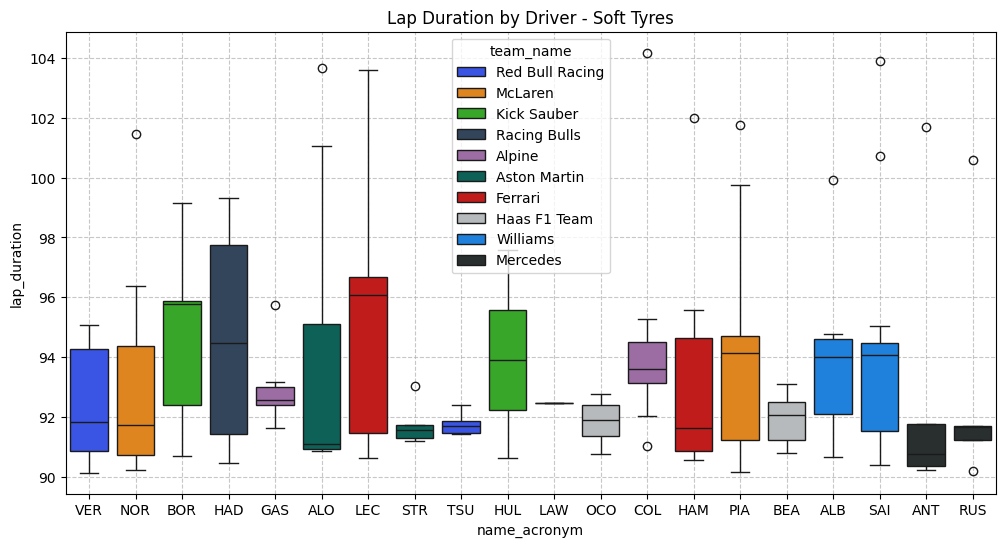

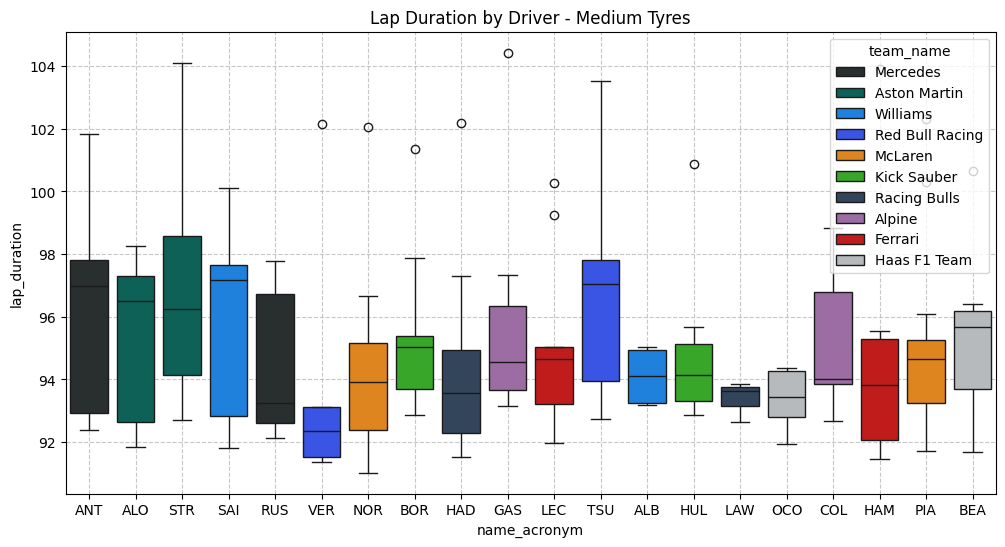

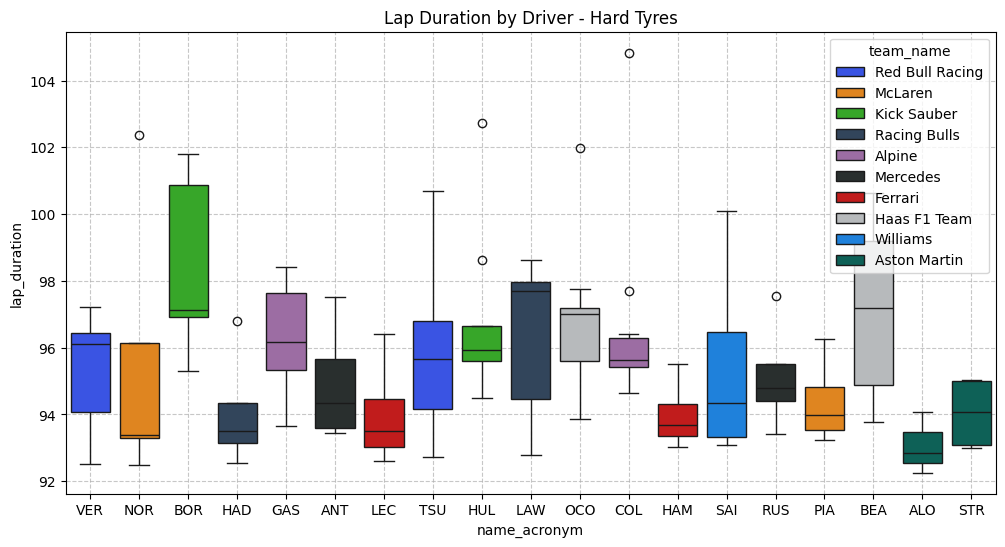

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
TEAM_COLORS = {
                        "Ferrari": "#DC0000",
                        "Mercedes": "#28302F",
                        "McLaren": "#FF8700",
                        "Red Bull Racing": "#1E41FF",
                        "Williams": "#0082FA",
                        "Aston Martin": "#006F62",
                        "Haas F1 Team": "#B6BABD",
                        "Alpine": "#A364AC",
                        "Racing Bulls": "#2B4562",
                        "Kick Sauber": "#27BB14"
                    }
#plot boxplot of lap_duration by drivers for all_fp_clean_filter_soft
plt.figure(figsize=(12, 6))
sns.boxplot(data=all_fp_clean_filter_soft, x="name_acronym", y="lap_duration", hue="team_name", palette=TEAM_COLORS)
#add grid
plt.grid(True, linestyle='--', alpha=0.7)
plt.title("Lap Duration by Driver - Soft Tyres")

#same plot for medium tyres
plt.figure(figsize=(12, 6))
sns.boxplot(data=all_fp_clean_filter_medium, x="name_acronym", y="lap_duration", hue="team_name", palette=TEAM_COLORS)
#add grid
plt.grid(True, linestyle='--', alpha=0.7)
plt.title("Lap Duration by Driver - Medium Tyres")
#same plot for hard tyres
plt.figure(figsize=(12, 6))

sns.boxplot(data=all_fp_clean_filter_hard, x="name_acronym", y="lap_duration", hue="team_name", palette=TEAM_COLORS)
#add grid
plt.grid(True, linestyle='--', alpha=0.7)
plt.title("Lap Duration by Driver - Hard Tyres")
plt.show()


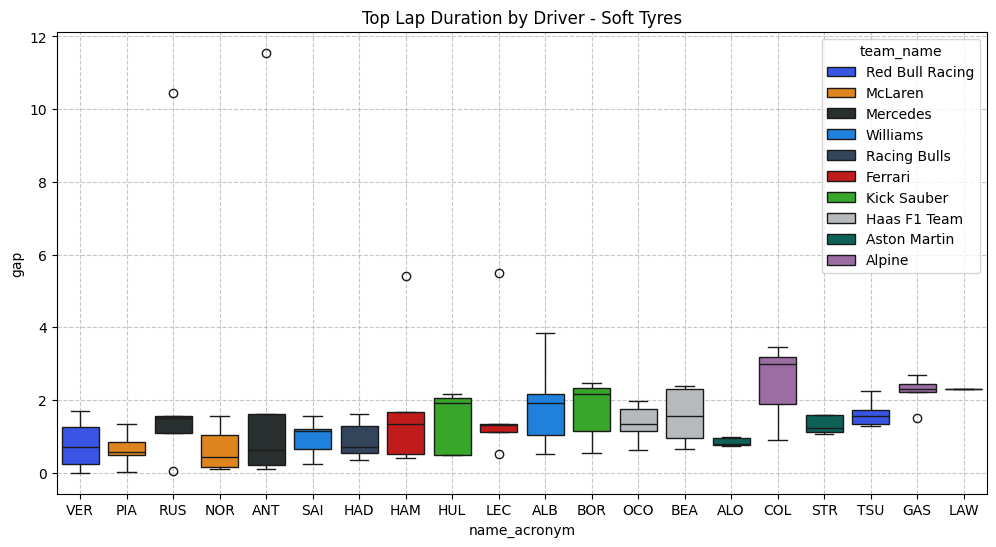

In [24]:
top_5_laps_soft = (
    all_fp_clean_filter_soft
    .dropna(subset=["lap_duration"])
    .sort_values(["driver_number", "lap_duration"], ascending=[True, True])
    .groupby("driver_number", as_index=False)
    .head(5)
    .reset_index(drop=True)
)

top_5_laps_soft = top_5_laps_soft.sort_values("lap_duration")
top_5_laps_soft["gap"]=top_5_laps_soft["lap_duration"] - top_5_laps_soft["lap_duration"].min()

plt.figure(figsize=(12, 6))
sns.boxplot(data=top_5_laps_soft, x="name_acronym", y="gap", hue="team_name", palette=TEAM_COLORS)
#
#add grid
plt.grid(True, linestyle='--', alpha=0.7)
plt.title("Top Lap Duration by Driver - Soft Tyres")
plt.show()

In [18]:
#TOP lap in soft for each driver
top_laps_soft = all_fp_clean_filter_soft.loc[all_fp_clean_filter_soft.groupby("driver_number")["lap_duration"].idxmin()]
top_laps_soft = top_laps_soft.sort_values("lap_duration")
top_laps_soft["gap"]=top_laps_soft["lap_duration"] - top_laps_soft["lap_duration"].min()


plt.figure(figsize=(12, 6))
sns.barplot(data=top_laps_soft, x="name_acronym", y="gap", hue="team_name", palette=TEAM_COLORS)
#
#add grid
plt.grid(True, linestyle='--', alpha=0.7)
plt.title("Top Lap Duration by Driver - Soft Tyres")
plt.show()


SyntaxError: invalid syntax (1210312924.py, line 2)

In [41]:
result_clean_verstappen = result_clean[result_clean["driver_number"] == 4]
result_clean_verstappen

,driver_number,lap_number,lap_duration,is_pit_out_lap,stint_number,compound,tyre_age_at_start,tyre_lap_start,tyre_lap_end,laps_on_tyre,laps_on_this_tyre,is_first_lap_on_tyre,is_last_lap_on_tyre,full_name,name_acronym,team_name,team_colour
17,4,2,92.379,False,1,MEDIUM,0,1,6,6,2,False,False,Lando NORRIS,NOR,McLaren,F47600
18,4,3,163.072,False,1,MEDIUM,0,1,6,6,3,False,False,Lando NORRIS,NOR,McLaren,F47600
19,4,4,124.534,False,1,MEDIUM,0,1,6,6,4,False,False,Lando NORRIS,NOR,McLaren,F47600
20,4,5,91.021,False,1,MEDIUM,0,1,6,6,5,False,False,Lando NORRIS,NOR,McLaren,F47600
23,4,8,96.674,False,2,MEDIUM,6,7,15,9,2,False,False,Lando NORRIS,NOR,McLaren,F47600
24,4,9,93.902,False,2,MEDIUM,6,7,15,9,3,False,False,Lando NORRIS,NOR,McLaren,F47600
25,4,10,93.845,False,2,MEDIUM,6,7,15,9,4,False,False,Lando NORRIS,NOR,McLaren,F47600
26,4,11,93.956,False,2,MEDIUM,6,7,15,9,5,False,False,Lando NORRIS,NOR,McLaren,F47600
27,4,12,94.440,False,2,MEDIUM,6,7,15,9,6,False,False,Lando NORRIS,NOR,McLaren,F47600
28,4,13,95.610,False,2,MEDIUM,6,7,15,9,7,False,False,Lando NORRIS,NOR,McLaren,F47600


In [31]:
drop=["session_name","lap_number","is_pit_out_lap","laps_on_this_tyre","is_first_lap_on_tyre","is_last_lap_on_tyre","full_name","team_name","team_colour"]
full_fp_clean_filter=all_fp_clean_filter.drop(columns=drop)

In [33]:
full_fp_clean_filter[full_fp_clean_filter["driver_number"]==4]

,session_code,driver_number,lap_duration,stint_number,compound,tyre_age_at_start,tyre_lap_start,tyre_lap_end,laps_on_tyre,name_acronym
25,FP1,4,96.140,1,HARD,0,1,9,9,NOR
27,FP1,4,93.388,1,HARD,0,1,9,9,NOR
29,FP1,4,93.286,1,HARD,0,1,9,9,NOR
31,FP1,4,92.493,1,HARD,0,1,9,9,NOR
32,FP1,4,102.366,1,HARD,0,1,9,9,NOR
34,FP1,4,91.698,2,SOFT,0,10,12,3,NOR
37,FP1,4,91.799,3,SOFT,3,13,16,4,NOR
39,FP1,4,101.461,3,SOFT,3,13,16,4,NOR
41,FP1,4,95.034,4,SOFT,7,17,22,6,NOR
43,FP1,4,92.374,4,SOFT,7,17,22,6,NOR


In [48]:
#create new variable binary best_lap_fp1, best_lap_fp2, best_lap_fp3 in full_fp_clean_filter
best_lap_fp1 = full_fp_clean_filter[full_fp_clean_filter["session_code"] == "FP1"]["lap_duration"].min()
full_fp_clean_filter["best_lap_fp1"] = full_fp_clean_filter.apply(lambda row: 1 if row["lap_duration"] == best_lap_fp1 and row["session_code"] == "FP1" else 0, axis=1)
best_lap_fp2 = full_fp_clean_filter[full_fp_clean_filter["session_code"] == "FP2"]["lap_duration"].min()
full_fp_clean_filter["best_lap_fp2"] = full_fp_clean_filter.apply(lambda row: 1 if row["lap_duration"] == best_lap_fp2 and row["session_code"] == "FP2" else 0, axis=1)
best_lap_fp3 = full_fp_clean_filter[full_fp_clean_filter["session_code"] == "FP3"]["lap_duration"].min()
full_fp_clean_filter["best_lap_fp3"] = full_fp_clean_filter.apply(lambda row: 1 if row["lap_duration"] == best_lap_fp3 and row["session_code"] == "FP3" else 0, axis=1)


In [50]:
full_fp_clean_filter[full_fp_clean_filter["best_lap_fp1"]==1]

,session_code,driver_number,lap_duration,stint_number,compound,tyre_age_at_start,tyre_lap_start,tyre_lap_end,laps_on_tyre,name_acronym,best_lap_fp1,best_lap_fp2,best_lap_fp3
168,FP1,14,91.116,3,SOFT,0,13,19,7,ALO,1,0,0


In [37]:
import pandas as pd
import numpy as np

# df = all_fp  OU  all_fp_clean_filter_soft  selon ce que tu as
df = all_fp.copy()  # <-- adapte le nom de ton DataFrame

# --- 0) Nettoyage minimal ---
# garder FP1/FP2/FP3
df = df[df["session_code"].isin(["FP1","FP2","FP3"])].copy()

# types
df["lap_duration"] = pd.to_numeric(df["lap_duration"], errors="coerce")
df = df.dropna(subset=["lap_duration", "driver_number"])

# virer les out-laps et les derniers tours d’un stint (souvent cool down)
if "is_pit_out_lap" in df.columns:
    df = df[~df["is_pit_out_lap"].fillna(False)]
if "is_last_lap_on_tyre" in df.columns:
    df = df[~df["is_last_lap_on_tyre"].fillna(False)]
if "laps_on_this_tyre" in df.columns:
    # écarter le tout premier tour des pneus si tu veux (optionnel) :
    df = df[df["laps_on_this_tyre"].fillna(2) >= 2]

# --- A) Classement meilleur tour global ---
best_overall = (
    df.sort_values(["driver_number", "lap_duration"], ascending=[True, True])
      .groupby("driver_number", as_index=False)
      .first()  # garde la ligne du meilleur tour
)

# Rank
best_overall = best_overall.sort_values("lap_duration").reset_index(drop=True)
best_overall["rank_bestlap_overall"] = np.arange(1, len(best_overall)+1)

cols_keep = [
    "rank_bestlap_overall", "driver_number", "name_acronym", "lap_duration",
    "session_code", "stint_number", "compound", "tyre_lap_start", "lap_number"
]
best_overall = best_overall[[c for c in cols_keep if c in best_overall.columns]]

print("=== Standing (meilleur tour global FP1–FP3) ===")
print(best_overall.head(20))


# --- B) Classement en PRIORISANT SOFT, sinon MED, sinon HARD ---
# On crée une priorité de compound
priority = {"SOFT": 0, "MEDIUM": 1, "HARD": 2}
df["compound_up"] = df["compound"].str.upper()
df["compound_priority"] = df["compound_up"].map(priority).fillna(99)

# On trie d’abord par priorité pneu, puis par lap time
pref = (
    df.sort_values(["driver_number", "compound_priority", "lap_duration"],
                   ascending=[True, True, True])
      .groupby("driver_number", as_index=False)
      .first()
)

pref = pref.sort_values(["compound_priority","lap_duration"]).reset_index(drop=True)
pref["rank_bestlap_pref_soft"] = np.arange(1, len(pref)+1)

cols_keep2 = [
    "rank_bestlap_pref_soft", "driver_number", "name_acronym", "compound", "lap_duration",
    "session_code", "stint_number", "tyre_lap_start", "lap_number"
]
pref = pref[[c for c in cols_keep2 if c in pref.columns]]

print("\n=== Standing (meilleur tour en priorité SOFT → MED → HARD) ===")
print(pref.head(20))

=== Standing (meilleur tour global FP1–FP3) ===
    rank_bestlap_overall  driver_number name_acronym  lap_duration  \
0                      1              1          VER        90.148   
1                      2             81          PIA        90.165   
2                      3             63          RUS        90.197   
3                      4              4          NOR        90.237   
4                      5             12          ANT        90.237   
5                      6             55          SAI        90.392   
6                      7              6          HAD        90.489   
7                      8             44          HAM        90.559   
8                      9             27          HUL        90.637   
9                     10             16          LEC        90.651   
10                    11             23          ALB        90.668   
11                    12              5          BOR        90.697   
12                    13             31   

In [39]:
pred=pref[["rank_bestlap_pref_soft","name_acronym"]]

,rank_bestlap_pref_soft,name_acronym
0,1,VER
1,2,PIA
2,3,RUS
3,4,NOR
4,5,ANT
5,6,SAI
6,7,HAD
7,8,HAM
8,9,HUL
9,10,LEC


In [59]:
import pandas as pd

def lap_to_seconds(s):
    """Convertit 'M:SS.mmm' en secondes float. Renvoie None si manquant."""
    if not s or pd.isna(s):
        return None
    m, rest = s.split(":")
    return int(m) * 60 + float(rest)

data = [
    # rank, name, team, driver_number, lap_time_str
    (1,  "G. Russell",      "Mercedes",      63, "1:29.158"),
    (2,  "M. Verstappen",   "Red Bull",       1, "1:29.340"),
    (3,  "O. Piastri",      "McLaren",       81, "1:29.524"),
    (4,  "K. Antonelli",    "Mercedes",      12, "1:29.537"),
    (5,  "L. Norris",       "McLaren",        4, "1:29.586"),
    (6,  "L. Hamilton",     "Ferrari",       44, "1:29.688"),
    (7,  "C. Leclerc",      "Ferrari",       16, "1:29.784"),
    (8,  "I. Hadjar",       "Racing Bulls",   6, "1:29.846"),
    (9,  "O. Bearman",      "Haas",          87, "1:29.868"),
    (10, "F. Alonso",       "Aston Martin",  14, "1:29.955"),
    (11, "N. Hulkenberg",   "Sauber",        27, "1:30.141"),
    (12, "A. Albon",        "Williams",      23, "1:30.202"),
    (13, "C. Sainz Jr.",    "Williams",      55, "1:30.235"),
    (14, "L. Lawson",       "Racing Bulls",  30, "1:30.320"),
    (15, "Y. Tsunoda",      "Red Bull",      22, "1:30.353"),
    (16, "G. Bortoleto",    "Sauber",         5, "1:30.820"),
    (17, "L. Stroll",       "Aston Martin",  18, "1:30.949"),
    (18, "F. Colapinto",    "Alpine",        43, "1:30.982"),
    (19, "E. Ocon",         "Haas",          31, "1:30.989"),
    # Gasly: info incomplète dans ton message → je mets rang 20 et laisse à compléter
    (20, "P. Gasly",        None,            None, None),
]

reality = pd.DataFrame(data, columns=["rank","name","team","driver_number","lap_time_str"])
reality["lap_time_s"] = reality["lap_time_str"].apply(lap_to_seconds)

# (Optionnel) acronyms usuels si tu veux merger avec 'name_acronym'
acronym_map = {
    "G. Russell":"RUS","M. Verstappen":"VER","O. Piastri":"PIA","K. Antonelli":"ANT",
    "L. Norris":"NOR","L. Hamilton":"HAM","C. Leclerc":"LEC","I. Hadjar":"HAD",
    "O. Bearman":"BEA","F. Alonso":"ALO","N. Hulkenberg":"HUL","A. Albon":"ALB",
    "C. Sainz Jr.":"SAI","L. Lawson":"LAW","Y. Tsunoda":"TSU","G. Bortoleto":"BOR",
    "L. Stroll":"STR","F. Colapinto":"COL","E. Ocon":"OCO","P. Gasly":"GAS"
}
reality["name_acronym"] = reality["name"].map(acronym_map)

print(reality)


    rank           name          team  driver_number lap_time_str  lap_time_s  \
0      1     G. Russell      Mercedes           63.0     1:29.158      89.158   
1      2  M. Verstappen      Red Bull            1.0     1:29.340      89.340   
2      3     O. Piastri       McLaren           81.0     1:29.524      89.524   
3      4   K. Antonelli      Mercedes           12.0     1:29.537      89.537   
4      5      L. Norris       McLaren            4.0     1:29.586      89.586   
5      6    L. Hamilton       Ferrari           44.0     1:29.688      89.688   
6      7     C. Leclerc       Ferrari           16.0     1:29.784      89.784   
7      8      I. Hadjar  Racing Bulls            6.0     1:29.846      89.846   
8      9     O. Bearman          Haas           87.0     1:29.868      89.868   
9     10      F. Alonso  Aston Martin           14.0     1:29.955      89.955   
10    11  N. Hulkenberg        Sauber           27.0     1:30.141      90.141   
11    12       A. Albon     

In [60]:
reality=reality[["rank","name_acronym"]]

In [62]:
#compute RMSE between reality and pred
full_pred_reality= pred.merge(reality,on="name_acronym",how="inner")
full_pred_reality["squared_error"] = (full_pred_reality["rank_bestlap_pref_soft"] - full_pred_reality["rank"]) ** 2
rmse = np.sqrt(full_pred_reality["squared_error"].mean())
rmse

3.3763886032268267

In [63]:
full_pred_reality


,rank_bestlap_pref_soft,name_acronym,rank,squared_error
0,1,VER,2,1
1,2,PIA,3,1
2,3,RUS,1,4
3,4,NOR,5,1
4,5,ANT,4,1
5,6,SAI,13,49
6,7,HAD,8,1
7,8,HAM,6,4
8,9,HUL,11,4
9,10,LEC,7,9


In [80]:
full_fp_clean_filter

,session_code,driver_number,lap_duration,stint_number,compound,tyre_age_at_start,tyre_lap_start,tyre_lap_end,laps_on_tyre,name_acronym,best_lap_fp1,best_lap_fp2,best_lap_fp3
1,FP1,1,95.501,1,HARD,0,1,5,5,VER,0,0,0
3,FP1,1,94.059,1,HARD,0,1,5,5,VER,0,0,0
6,FP1,1,93.011,2,HARD,5,6,10,5,VER,0,0,0
8,FP1,1,92.514,2,HARD,5,6,10,5,VER,0,0,0
11,FP1,1,91.854,3,SOFT,0,11,16,6,VER,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,FP3,87,95.663,2,MEDIUM,8,9,15,7,BEA,0,0,0
1254,FP3,87,95.704,2,MEDIUM,8,9,15,7,BEA,0,0,0
1255,FP3,87,100.653,2,MEDIUM,8,9,15,7,BEA,0,0,0
1257,FP3,87,90.799,3,SOFT,0,16,24,9,BEA,0,0,0


In [81]:
full_fp_clean_filter.groupby("compound").groupby("session_code").min()["lap_duration"]

AttributeError: 'DataFrameGroupBy' object has no attribute 'groupby'

<Axes: xlabel='session_code', ylabel='lap_duration'>

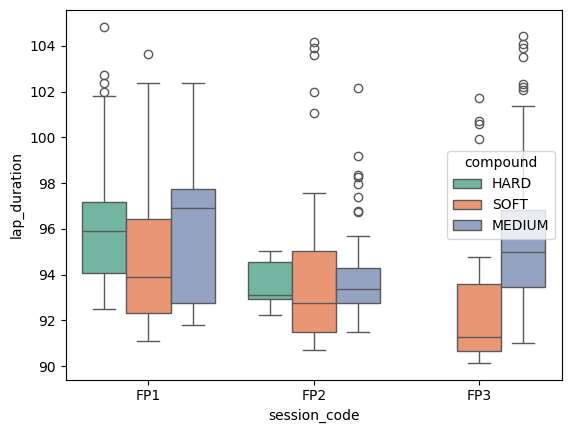

In [82]:
sns.boxplot(data=full_fp_clean_filter, x="session_code", y="lap_duration", hue="compound", palette="Set2")

C:\Users\lucas\AppData\Local\Temp\ipykernel_13460\3394300228.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=full_fp_clean_filter, x="compound", y="lap_duration", palette="Set2")


<Axes: xlabel='compound', ylabel='lap_duration'>

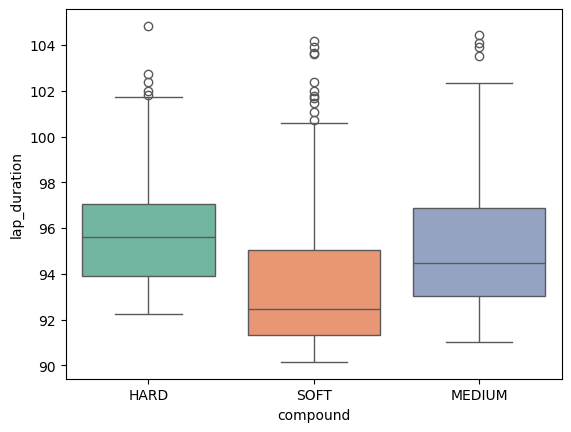

In [86]:
sns.boxplot(data=full_fp_clean_filter, x="compound", y="lap_duration", palette="Set2")


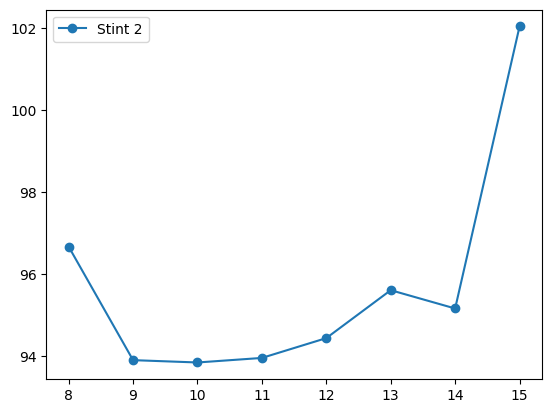

In [108]:
full_fp_norris = all_fp[all_fp["driver_number"] == 4]
full_fp_norris_f3=full_fp_norris[full_fp_norris["session_code"]=="FP3"]
full_fp_norris_f3=full_fp_norris_f3[full_fp_norris_f3["lap_duration"]<150]
#full_fp_norris_f3 restricted to lap 7 to 15 
full_fp_norris_f3=full_fp_norris_f3[(full_fp_norris_f3["lap_number"]>=7) & (full_fp_norris_f3["lap_number"]<=15)]
#plot time series for each stint
import matplotlib.pyplot as plt
for stint, group in full_fp_norris_f3.groupby('stint_number'):
    plt.plot(group['lap_number'], group['lap_duration'], marker='o', label=f'Stint {stint}')
plt.legend()
#!/usr/bin/env python3

In [106]:
full_fp_norris_f3

,session_code,session_name,driver_number,lap_number,lap_duration,is_pit_out_lap,stint_number,compound,tyre_age_at_start,tyre_lap_start,tyre_lap_end,laps_on_tyre,laps_on_this_tyre,is_first_lap_on_tyre,is_last_lap_on_tyre,full_name,name_acronym,team_name,team_colour
841,FP3,Practice 3,4,1,NaN,True,1,MEDIUM,0,1,6,6,1,True,False,Lando NORRIS,NOR,McLaren,F47600
842,FP3,Practice 3,4,2,92.379,False,1,MEDIUM,0,1,6,6,2,False,False,Lando NORRIS,NOR,McLaren,F47600
843,FP3,Practice 3,4,3,163.072,False,1,MEDIUM,0,1,6,6,3,False,False,Lando NORRIS,NOR,McLaren,F47600
844,FP3,Practice 3,4,4,124.534,False,1,MEDIUM,0,1,6,6,4,False,False,Lando NORRIS,NOR,McLaren,F47600
845,FP3,Practice 3,4,5,91.021,False,1,MEDIUM,0,1,6,6,5,False,False,Lando NORRIS,NOR,McLaren,F47600
846,FP3,Practice 3,4,6,NaN,False,1,MEDIUM,0,1,6,6,6,False,True,Lando NORRIS,NOR,McLaren,F47600
847,FP3,Practice 3,4,7,874.601,True,2,MEDIUM,6,7,15,9,1,True,False,Lando NORRIS,NOR,McLaren,F47600
848,FP3,Practice 3,4,8,96.674,False,2,MEDIUM,6,7,15,9,2,False,False,Lando NORRIS,NOR,McLaren,F47600
849,FP3,Practice 3,4,9,93.902,False,2,MEDIUM,6,7,15,9,3,False,False,Lando NORRIS,NOR,McLaren,F47600
850,FP3,Practice 3,4,10,93.845,False,2,MEDIUM,6,7,15,9,4,False,False,Lando NORRIS,NOR,McLaren,F47600
